In [26]:
import pandas as pd
import numpy as np
import os
import pandas as pd

from tqdm import tqdm 
tqdm.pandas(desc="progress-bar") 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.utils import resample
import xgboost as xgb 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

import shap # Ling > !pip3 install shap works. conda or pip install shap does not work. 
from lime import lime_text # explain the model result

# packages for w2v
import spacy
import gensim
import nltk
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full
from gensim.models import word2vec

# plot packages for w2v-part
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
sns.set_style("darkgrid")

# Load saved data

In [27]:
from os.path import dirname

path = dirname(os.getcwd())
path

'c:\\Users\\EQDIYCI\\OneDrive - Allianz\\TRAININGS\\DATASCIENCE_ACADEMY\\PROJECT'

In [28]:
data_en = pd.read_pickle(path + "\data\processed\data_en3.pickle")

In [29]:
data_en.head()

marketplace  customer_id       review_id  product_id  product_parent   
0          US     12039526   RTIS3L2M1F5SM  B001CXYMFS       737716809  \
1          US      9636577   R1ZV7R40OLHKD  B00M920ND6       569686175   
2          US      2331478  R3BH071QLH8QMC  B0029CSOD2        98937668   
3          US     52495923  R127K9NTSXA2YH  B00GOOSV98        23143350   
4          US     14533949  R32ZWUXDJPW27Q  B00Y074JOM       821342511   

                                       product_title product_category   
0         Thrustmaster T-Flight Hotas X Flight Stick      Video Games  \
1  Tonsee 6 buttons Wireless Optical Silent Gamin...      Video Games   
2  Hidden Mysteries: Titanic Secrets of the Fatef...      Video Games   
3  GelTabz Performance Thumb Grips - PlayStation ...      Video Games   
4  Zero Suit Samus amiibo - Japan Import (Super S...      Video Games   

   star_rating  helpful_votes  total_votes vine verified_purchase   
0            5              0            0    N                 Y  \
1            5              0            0    N                 Y   
2            1              0            1    N                 Y   
3            3              0            0    N                 Y   
4            4              0            0    N                 Y   

                                     review_headline   
0  an amazing joystick. I especially love that yo...  \
1  Definitely a silent mouse... Not a single clic...   
2                                           One Star   
3                          good, but could be bettee   
4                                  Great but flawed.   

                                         review_body review_date language   
0  Used this for Elite Dangerous on my mac, an am...  2015-08-31       EN  \
1  Loved it,  I didn't even realise it was a gami...  2015-08-31       EN   
2     poor quality work and not as it is advertised.  2015-08-31       EN   
3  nice, but tend to slip away from stick in inte...  2015-08-31       EN   
4  Great amiibo, great for collecting. Quality ma...  2015-08-31       EN   

                                   processed_reviews   
0  use elit danger mac amaz joystick especi love ...  \
1  love even realis game mous type silent mous se...   
2                              poor qualiti advertis   
3  nice tend slip away stick intens hard press ga...   
4  great amiibo great collect qualiti materi desi...   

                                     lem_pos_ner_rem   
0  use_VERB this_PRON for_ADP on_ADP my_PRON mac_...  \
1  love_VERB it_PRON I_PRON do_AUX not_PART even_...   
2  poor_ADJ quality_NOUN work_NOUN and_CCONJ not_...   
3  nice_ADJ but_CCONJ tend_VERB to_PART slip_VERB...   
4  great_ADJ amiibo_NOUN great_ADJ for_ADP collec...   

                                head_lem_pos_ner_rem  
0  an_DET amazing_ADJ joystick_NOUN I_PRON especi...  
1  definitely_ADV a_DET silent_ADJ mouse_NOUN not...  
2                                          star_NOUN  
3    good_ADJ but_CCONJ could_AUX be_AUX bettee_VERB  
4                     great_ADJ but_CCONJ flawed_ADJ

# Undersampling to reduce calculation load and balance data

In [30]:
# need to convert column type to string, otherwise there is float in title --> cannot combine two columns head and review body
data_en['review_headline'] = data_en['review_headline'].astype(str)

In [31]:
data_en["lem_comb"] =  data_en[["lem_pos_ner_rem", "head_lem_pos_ner_rem"]].apply(lambda x: x["head_lem_pos_ner_rem"] + " " + x["lem_pos_ner_rem"] , axis=1)
data_en["head_body"] = data_en[["review_headline", "processed_reviews"]].apply(lambda x: x["review_headline"] + " " + x["processed_reviews"] , axis=1)

In [32]:
data_en[['lem_comb', 'head_body']].sample(5)

lem_comb   
939098   great_ADJ multiplayer_NOUN but_CCONJ again_ADV...  \
1754627  finally_ADV the_DET Rock_PROPN have_AUX come_V...   
443522                       star_NOUN great_ADJ game_NOUN   
1772420  be_AUX not_PART really_ADV wild_ADJ Wild_PROPN...   
1663533  be_AUX look_VERB for_ADP the_DET Perfect_PROPN...   

                                                 head_body  
939098   great multiplayer....but.... great game time m...  
1754627  Finally the Rock has come back to Playstation ...  
443522                               Five Stars great game  
1772420  Wild Metal isn't really wild wild metal wow ga...  
1663533  Been Looking for the Perfect Baseball Game sin...

In [33]:
# using combined headline and reviewbody for training
X = data_en['lem_comb']  
X_wo_pos = data_en['head_body']
y = data_en["star_rating"]

In [34]:
print(X.shape)
print(X_wo_pos.shape)

(1753198,)
(1753198,)


In [35]:
X.head()

0    an_DET amazing_ADJ joystick_NOUN I_PRON especi...
1    definitely_ADV a_DET silent_ADJ mouse_NOUN not...
2    star_NOUN poor_ADJ quality_NOUN work_NOUN and_...
3    good_ADJ but_CCONJ could_AUX be_AUX bettee_VER...
4    great_ADJ but_CCONJ flawed_ADJ great_ADJ amiib...
Name: lem_comb, dtype: object

In [36]:
X_wo_pos.head()

0    an amazing joystick. I especially love that yo...
1    Definitely a silent mouse... Not a single clic...
2                       One Star poor qualiti advertis
3    good, but could be bettee nice tend slip away ...
4    Great but flawed. great amiibo great collect q...
Name: head_body, dtype: object

In [37]:
y.head()

0    5
1    5
2    1
3    3
4    4
Name: star_rating, dtype: int64

In [38]:
# undersample the data
rs = [resample(X[y == sr], y[y == sr], X_wo_pos[y == sr], replace=False, 
    n_samples=int(np.floor(1*(X_wo_pos[y == 2].shape[0]))), random_state=123) for sr in [1, 2, 3, 4, 5]]

In [39]:
rs[1][0]

1697230    very_ADV frustrating_ADJ now_ADV there_PRON ha...
1064733    too_ADV different_ADJ the_DET game_NOUN be_AUX...
1512502    way_NOUN over_ADV rate_VERB the_DET graphic_NO...
607012     Fun_PROPN but_CCONJ trouble_VERB XCOM_NOUN ene...
406632     prepare_VERB your_PRON soul_NOUN for_ADP this_...
                                 ...                        
1316474    Stalker_PROPN C_PROPN of_ADP p_NOUN I_PRON kee...
1294879    frustrate_VERB the_DET service_NOUN be_AUX fas...
440312     star_NOUN never_ADV figure_VERB out_ADP how_SC...
664775     the_DET walk_VERB dead_ADJ survival_NOUN insti...
396032     possibly_ADV great_ADJ game_NOUN ruin_VERB by_...
Name: lem_comb, Length: 93921, dtype: object

In [40]:
rs[1][2]

1697230    Very frustrating bad star war game one first s...
1064733    Too different game complet declin ac answer gr...
1512502    Way over rated graphic game decent extrem repe...
607012     Fun, but troubled xcom enemi within tremend fu...
406632     Prepare your soul for this abomination multipl...
                                 ...                        
1316474    Stalker C of P keep comment pithi game drag ac...
1294879    frustrated servic fast game crash alot especi ...
440312        Two Stars never figur suppos use instruct noth
664775     The walking dead:survival instinct - Xbox 360 ...
396032     Possibly great game ruined by definitely broke...
Name: head_body, Length: 93921, dtype: object

In [41]:
X_list = [rs[r][0] for r in range(5)] # with postagging
y_list = [rs[r][1] for r in range(5)]
# X_list = [rs[r][2] for r in range(5)]

X_us = np.hstack(X_list)
y_us = np.hstack(y_list)

In [42]:
print(X_us.shape)
print(y_us.shape)

(469605,)
(469605,)


In [43]:
X_us

array([" I_PRON purchase_VERB this_DET remote_ADJ control_NOUN to_PART make_VERB watch_VERB DVD_PROPN 's_PART on_ADP the_DET easier_ADV I_PRON have_VERB problem_NOUN get_VERB it_PRON to_PART work_VERB consistantly_ADV right_ADV out_ADP of_ADP the_DET box_NOUN I_PRON have_VERB to_PART press_VERB most_ADJ of_ADP the_DET button_NOUN very_ADV hard_ADV to_PART get_VERB they_PRON to_PART work_VERB I_PRON hope_VERB it_PRON would_AUX get_VERB well_ADJ but_CCONJ it_PRON only_ADV get_VERB bad_ADJ I_PRON be_AUX now_ADV back_ADV to_ADP use_VERB the_DET game_NOUN controler_NOUN and_CCONJ throw_VERB the_DET remote_ADJ control_NOUN away_ADV br_X br_X would_AUX never_ADV recommend_VERB this_DET product_NOUN",
       "ditto_NOUN Game_PROPN will_AUX not_PART work_VERB THQ_PROPN web_NOUN help_NOUN pathetic_ADJ same_ADJ as_ADP the_DET other_NOUN waste_NOUN of_ADP money_NOUN and_CCONJ major_ADJ disappointment_NOUN will_AUX not_PART work_VERB even_ADV with_ADP compatibility_NOUN issue_NOUN fix_VERB can_AUX 

# Function definitions

In [44]:
#from sklearn.base import BaseEstimator, TransformerMixin
# Comment Ling: is this function in use?
class ModifiedLabelEncoder(LabelEncoder):

    def fit_transform(self, y, *args, **kwargs):
        return y.todense()-1

    def transform(self, y, *args, **kwargs):
        return y.todense()-1

In [45]:
def assess_on_val(clf, X_val_vectorized, y_val):
    '''
    plot the assessment of the prediction result
    '''
    print("Start predicting")
    predicted = clf.predict(X_val_vectorized)
    print("Finished predicting")
    total_accuracy = metrics.accuracy_score(predicted, y_val)

    accuracy_by_rating_class = {rc : metrics.accuracy_score(predicted[y_val==rc], y_val[y_val==rc]) for rc in np.unique(y_val)}
    accuracy_by_rating_class = pd.DataFrame.from_dict(accuracy_by_rating_class, orient="index")

    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(131)
    accuracy_by_rating_class.sort_index().plot(kind = "bar", ax = ax)
    ax.set_title("Accuracy per  \nrating class")
    ax.axhline(y = total_accuracy, color ='r', linestyle = '--')
    ax.get_legend().remove()
    ax.set_ylim(0,1)

    ax2 = fig.add_subplot(132)
    pd.DataFrame({"star_rating": predicted}).value_counts(normalize=1).reset_index().set_index("star_rating").sort_index().plot(kind="bar", ax=ax2)
    ax2.set_title("Percentage of \n predicted rating class")
    ax2.get_legend().remove()
    ax2.set_ylim(0,1)

    ax3 = fig.add_subplot(133)
    pd.DataFrame({"star_rating": y_val}).value_counts(normalize=1).reset_index().set_index("star_rating").sort_index().plot(kind="bar", ax=ax3)
    ax3.set_title("Percentage of actual \n rating classes in val")
    ax3.get_legend().remove()
    ax3.set_ylim(0,1)    
    fig.suptitle(str(clf._final_estimator), y=1.1)
    
    print("Global accuracy: " + str(total_accuracy))
    return fig

In [46]:
def model_interpretation(x_val, y_val):
    '''
    print out the classification report of the prediction result
    '''
    print(classification_report(y_val, pipeline.predict(X_val)))

    confusion_matrix = pd.crosstab(y_val, pipeline.predict(X_val), rownames=['Actual class'], colnames=['Predicted class'], normalize=1)
    confusion_matrix

In [47]:
## Plot roc
def plot_roc(X_test, y_test, model):
    '''
    create plot roc
    '''
    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    predicted_prob  = model.predict_proba(X_test)

    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                            predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3, 
                label='{0} (area={1:0.2f})'.format(classes[i], 
                                metrics.auc(fpr, tpr))
                )
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
            xlabel='False Positive Rate', 
            ylabel="True Positive Rate (Recall)", 
            title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)
    
## Plot precision-recall curve
def plot_precision_recall_curve(X_test, y_test, model):
    '''
    create precision and recall curve
    '''
    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    predicted_prob  = model.predict_proba(X_test)

    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                    y_test_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, 
                label='{0} (area={1:0.2f})'.format(classes[i], 
                                    metrics.auc(recall, precision))
                )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
            ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)


In [48]:
def explain_obv(y_train, X_val, y_val, model, i, n_features):
    '''
    explain the selected observation with the model
    '''
    ## select observation
    txt_instance = X_val[i]
    ## check true value and predicted value
    print("True:", y_val[i], "--> Pred:", model.predict(X_val)[i], "| Prob:", round(np.max(model.predict_proba(X_val)[i]),2))

    ## show explanation
    explainer = lime_text.LimeTextExplainer(class_names= np.unique(y_train))
    explained = explainer.explain_instance(txt_instance, model.predict_proba, num_features=n_features)
    explained.show_in_notebook(text=txt_instance, predict_proba=False)

# Split data into train, test and val

In [49]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X_us, y_us, test_size= 0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, random_state=42)

# Illustrate class imbalance

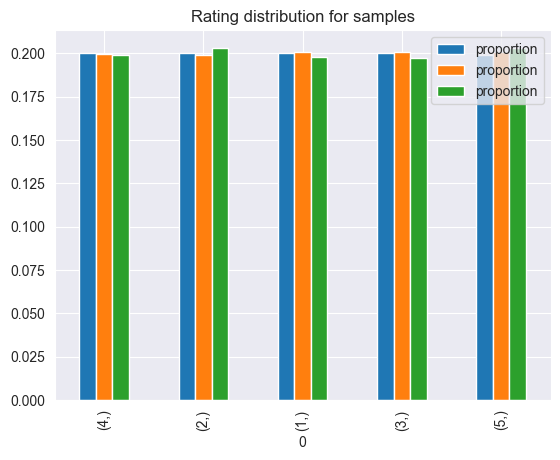

In [50]:
pd.concat([pd.DataFrame(x).value_counts(normalize=1) for x in [y_train, y_val, y_test]], axis=1).rename({0:"train", 1:"val", 2:"test"}, axis=1).plot(kind="bar")
plt.title("Rating distribution for samples");

# Pipeline: logistic regression and xbg


In [51]:
#help(LabelEncoder)

In [52]:
def selpc_fun(X,y):
        f = X.mean(axis=0)
        f = np.asarray(f).ravel()
        return f

def selpc_fun_inv(X,y):
        f = -1.0*X.mean(axis=0)
        f = np.asarray(f).ravel()
        return f

# Parameters
lr_params = dict(C=0.5, max_iter=1000)#, multi_class = "multinomial")
# lr_params = dict(multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1) 
vectorizer_params = dict(ngram_range=(1, 3), min_df=0.0001, max_df=0.35-0.25)#, max_features=10000) # 0.001 performs good and reduces runtime
tfidf_params = dict(norm='l2')
varth_params = dict(threshold=0.00005/100)
percth_params = dict(score_func= selpc_fun, percentile = 95)

# Supervised Pipeline
# pipeline for xgb
clf_xgb = xgb.XGBClassifier(
                base_score=0.2, booster='gbtree', colsample_bylevel=0.8,
                colsample_bynode=1, colsample_bytree=0.9, eval_metric='mlogloss',
                gamma=0, gpu_id=-1, importance_type='gain',
                interaction_constraints='', learning_rate=0.05,
                max_delta_step=0, max_depth=25, min_child_weight=1,# missing=nan,
                monotone_constraints='()', n_estimators=25, n_jobs=12,
                num_parallel_tree=1, objective='multi:softprob', random_state=0,
                reg_alpha=0.3, reg_lambda=1, scale_pos_weight=None, subsample=1,
                tree_method='exact', #use_label_encoder=True,
                validate_parameters=1, verbosity=None
        )

xgb_steps = [ ("vect", CountVectorizer(**vectorizer_params)),
        ("tfidf", TfidfTransformer(**tfidf_params)),
        #("le", ModifiedLabelEncoder()),
        #("percth", SelectPercentile(**percth_params)),
        #("varth", VarianceThreshold(**varth_params)),
        ("clf", clf_xgb)]

# pipeline for logistic regression 
lr_steps = [ ("vect", CountVectorizer(**vectorizer_params)),
        ("tfidf", TfidfTransformer(**tfidf_params)),
        #("percth", SelectPercentile(**percth_params)),
        #("varth", VarianceThreshold(**varth_params)),
        ("clf", LogisticRegression(**lr_params))]

# pipeline for logistic regression for word2vec
lr_steps_w2v = [("clf", LogisticRegression(**lr_params))] 

## logistic regression

### prediction

In [53]:
%%time
pipeline = Pipeline(lr_steps)
pipeline.fit(X_train, y_train)
print("Training_Score: ", pipeline.score(X_train, y_train), " / Val. Score: ", pipeline.score(X_val, y_val))

# multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1


# C=0.5, max_iter=1000
# Training_Score:  0.8241500835808818  / Val. Score:  0.7682015317892406

Training_Score:  0.7013411980991117  / Val. Score:  0.5735975752585516
CPU times: total: 13min 24s
Wall time: 14min 10s


### Interpretation

Start predicting
Finished predicting
Global accuracy: 0.5735975752585516


Predicted class         1         2         3         4         5
Actual class                                                     
1                0.660099  0.224076  0.046585  0.014297  0.016662
2                0.225526  0.496649  0.222979  0.043618  0.022034
3                0.072632  0.221682  0.500115  0.198237  0.057995
4                0.024112  0.043232  0.193108  0.522077  0.242047
5                0.017632  0.014361  0.037214  0.221771  0.661263

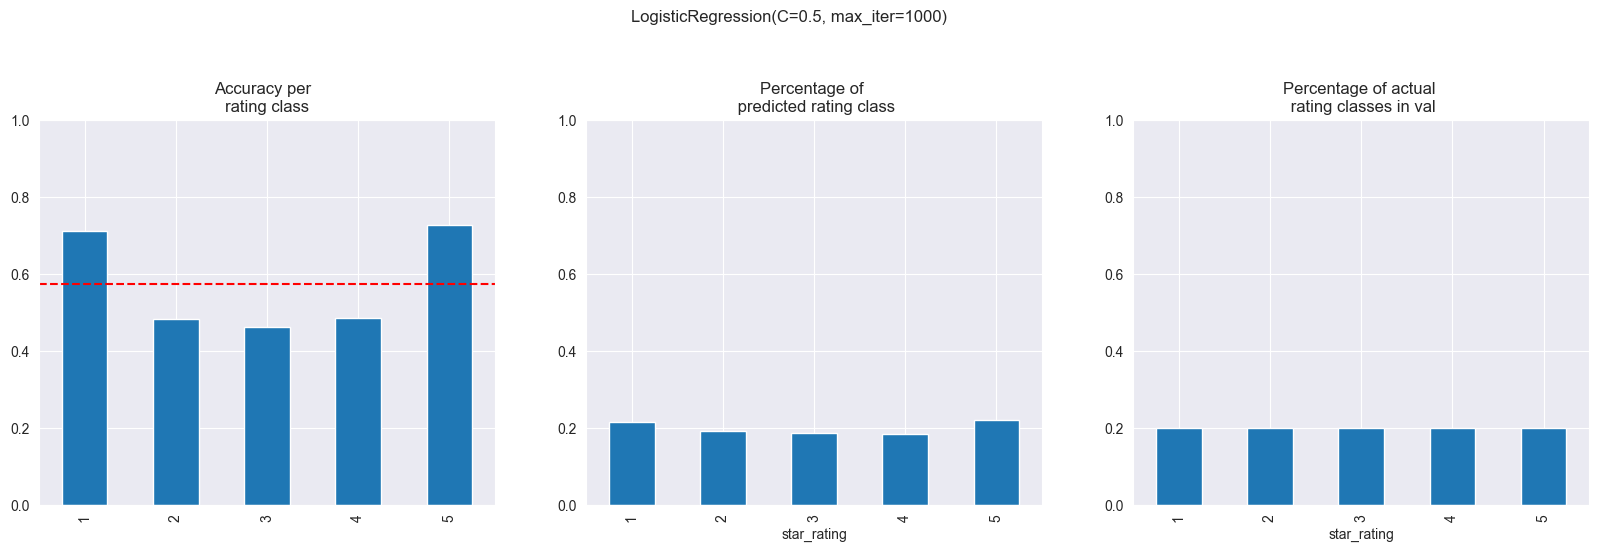

In [58]:
assess_on_val(pipeline, X_val, y_val)

confusion_matrix = pd.crosstab(
        y_val, pipeline.predict(X_val), 
        rownames=['Actual class'], colnames=['Predicted class'], normalize=1
    )

confusion_matrix

# lr_params = dict(C=0.5, max_iter=1000)
# Global accuracy: 0.5735975752585516
# Predicted class	1	2	3	4	5
# Actual class					
# 1	0.660099	0.224076	0.046585	0.014297	0.016662
# 2	0.225526	0.496649	0.222979	0.043618	0.022034
# 3	0.072632	0.221682	0.500115	0.198237	0.057995
# 4	0.024112	0.043232	0.193108	0.522077	0.242047
# 5	0.017632	0.014361	0.037214	0.221771	0.661263

# lr_params = dict(multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1) 


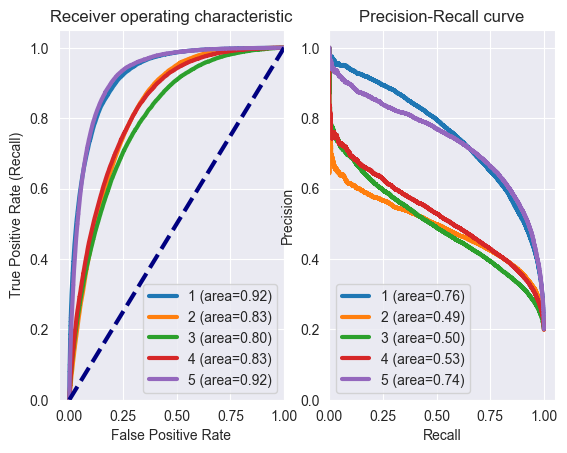

In [59]:

fig, ax = plt.subplots(nrows=1, ncols=2)

plot_roc(X_val ,y_val, pipeline)
plot_precision_recall_curve(X_val, y_val, pipeline)

plt.show()

In [60]:
pd.DataFrame(pipeline.predict(X_val)).value_counts()

# lr_params = dict(C=0.5, max_iter=1000)
# 5    31089
# 1    30400
# 2    27156
# 3    26146
# 4    26090

# lr_params = dict(multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1) 


5    31089
1    30400
2    27156
3    26146
4    26090
Name: count, dtype: int64

In [61]:
print(classification_report(y_val, pipeline.predict(X_val)))

# lr_params = dict(C=0.5, max_iter=1000)
#               precision    recall  f1-score   support

#            1       0.66      0.71      0.68     28261
#            2       0.50      0.48      0.49     27996
#            3       0.50      0.46      0.48     28279
#            4       0.52      0.48      0.50     28102
#            5       0.66      0.73      0.69     28243

#     accuracy                           0.57    140881
#    macro avg       0.57      0.57      0.57    140881
# weighted avg       0.57      0.57      0.57    140881

# lr_params = dict(multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1) 




              precision    recall  f1-score   support

           1       0.66      0.71      0.68     28261
           2       0.50      0.48      0.49     27996
           3       0.50      0.46      0.48     28279
           4       0.52      0.48      0.50     28102
           5       0.66      0.73      0.69     28243

    accuracy                           0.57    140881
   macro avg       0.57      0.57      0.57    140881
weighted avg       0.57      0.57      0.57    140881



#### Strongest and weakest features in prediction

In [62]:
tok_coef = pd.DataFrame(
    {
        "token": pipeline["vect"].get_feature_names_out()
        , "coef_1": pipeline["clf"].coef_[0,:]
        , "coef_2": pipeline["clf"].coef_[1,:]
        , "coef_3": pipeline["clf"].coef_[2,:]
        , "coef_4": pipeline["clf"].coef_[3,:]
        , "coef_5": pipeline["clf"].coef_[4,:]
    }
)

tok_coef.head()

token    coef_1    coef_2    coef_3    coef_4    coef_5
0               _part  0.393836 -0.607022  0.189588  0.137374 -0.113776
1  _part ability_noun -0.002530  0.142029 -0.094377 -0.093846  0.048725
2     _part and_cconj  0.095189 -0.144520  0.169068 -0.110622 -0.009116
3     _part face_noun -0.023371 -0.053671  0.002515 -0.014157  0.088684
4     _part game_noun  0.084038 -0.001200  0.059099 -0.191279  0.049342

In [63]:
tok_coef["delta"] = tok_coef["coef_5"] - tok_coef["coef_1"]
tok_coef["abs_delta"] = np.abs(tok_coef["delta"]) 

num = 40

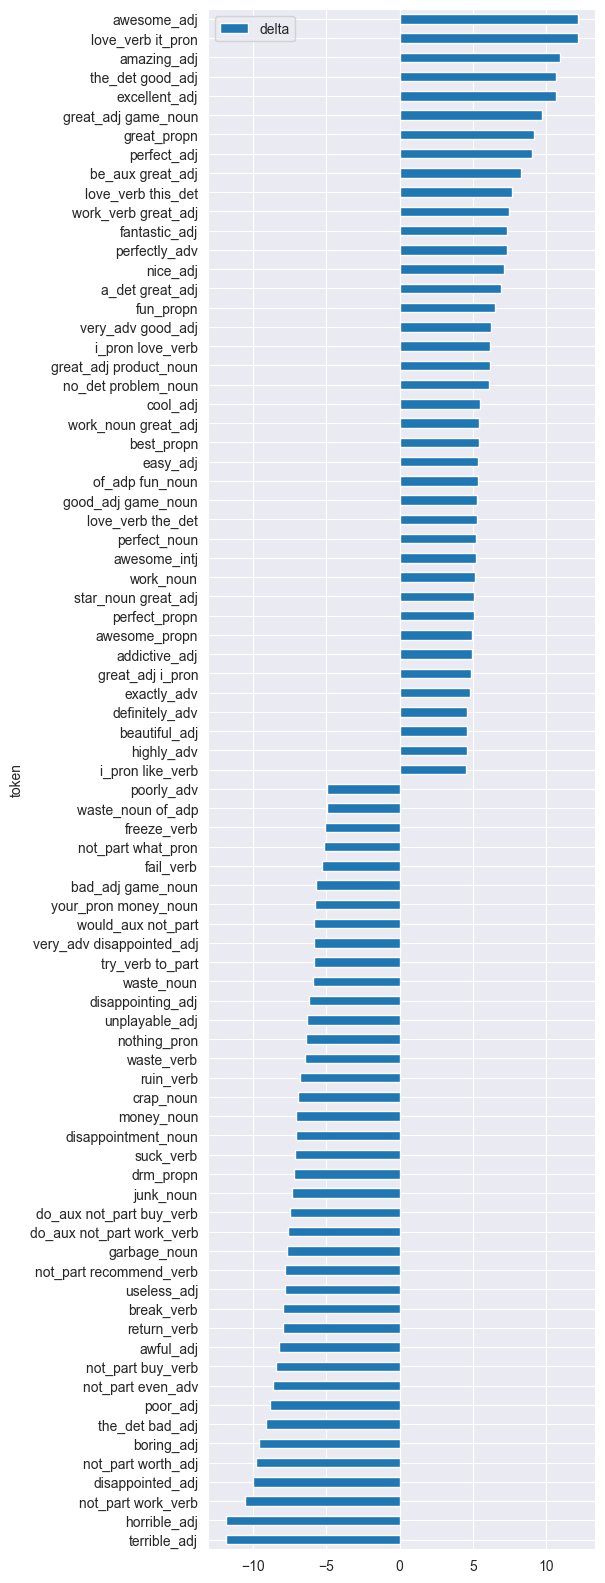

In [64]:
# strongest words for rating 5 and rating 1 predictions
strongest_words = pd.concat(
        [tok_coef.sort_values("delta").head(num), 
        tok_coef.sort_values("delta").tail(num)]
    )[["token", "delta"]].set_index("token").plot(kind="barh", figsize=(5,20))


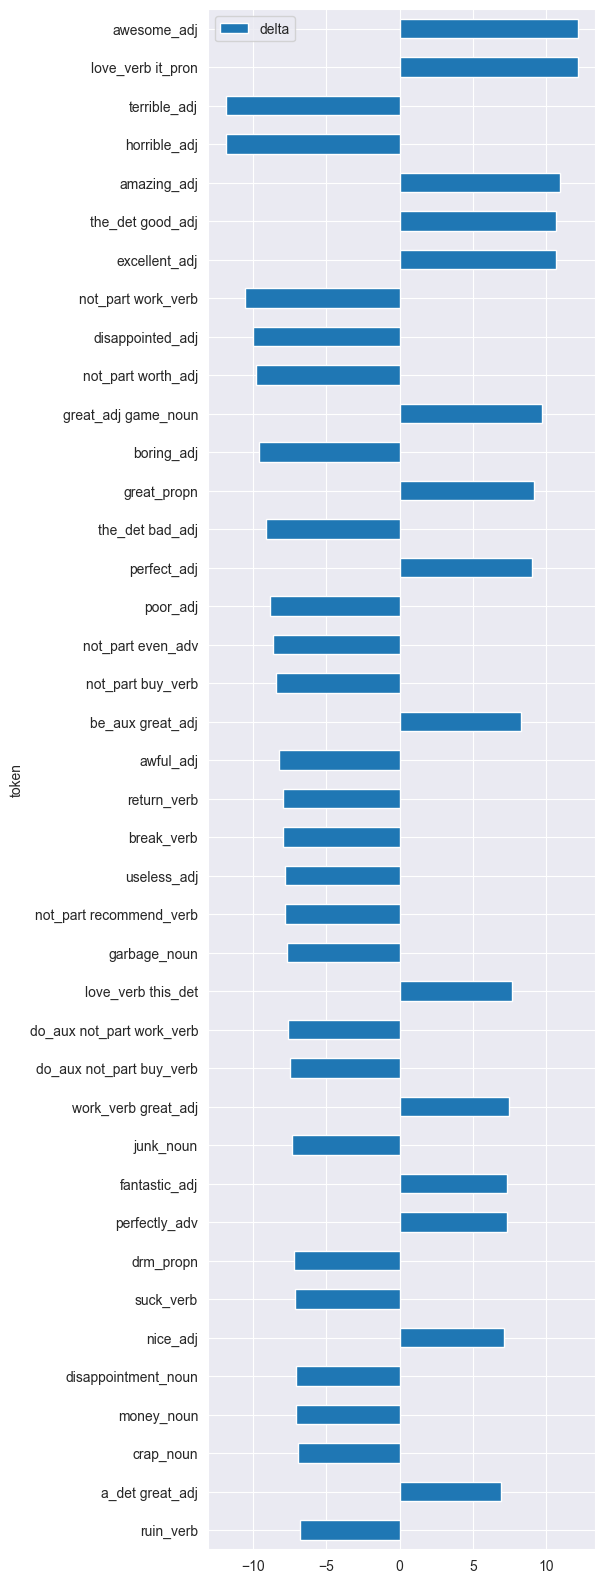

In [65]:
# strongest words (mixing positive and negative ratings)
strongest_words2 = tok_coef.sort_values("abs_delta").tail(num)[
    ["token", "delta"]].set_index("token").plot(kind="barh", figsize=(5,20))

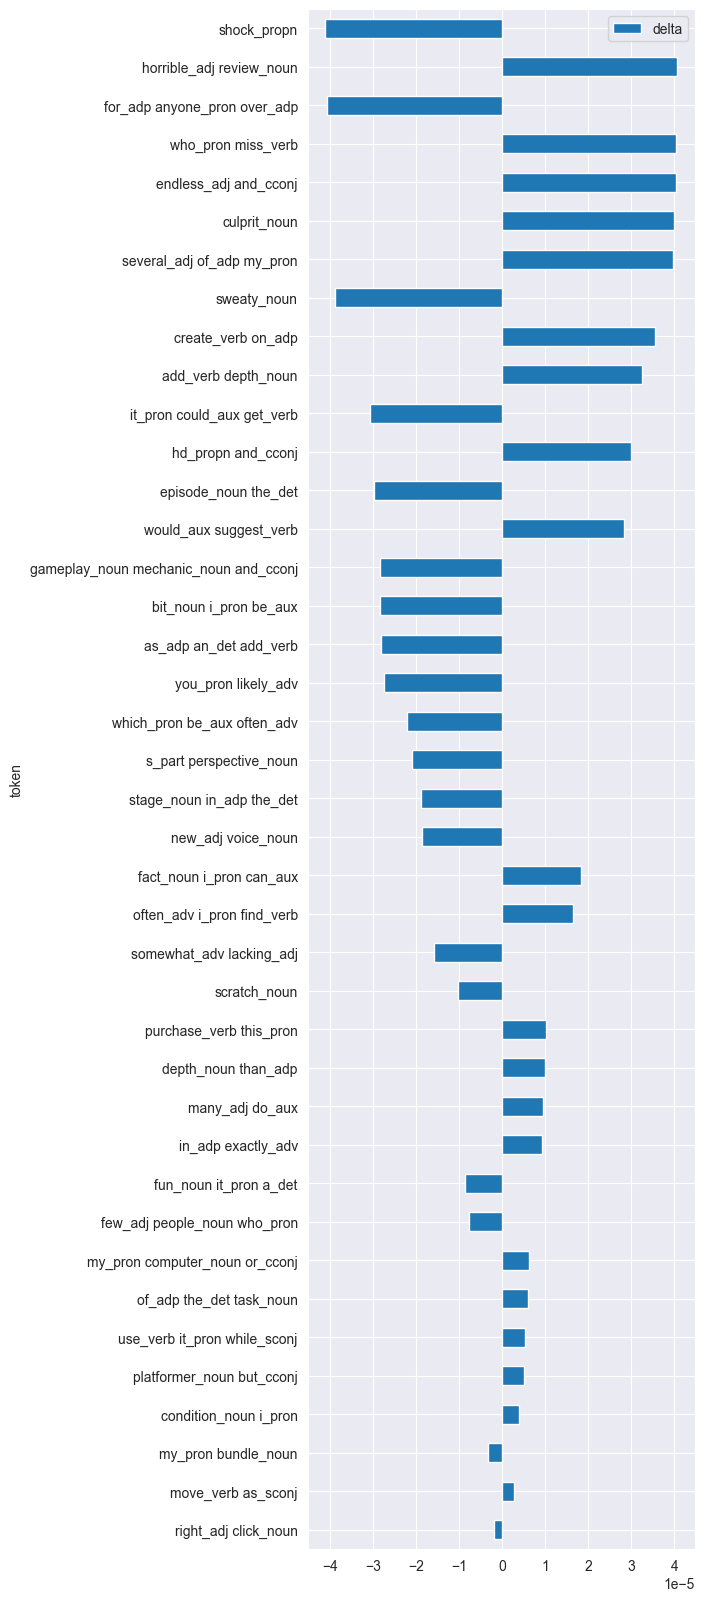

In [66]:
# weakest words (mixing positive and negative ratings)
weakest_words = tok_coef.sort_values("abs_delta").head(40)[
    ["token", "delta"]].set_index("token").plot(kind="barh", figsize=(5,20))

<Axes: >

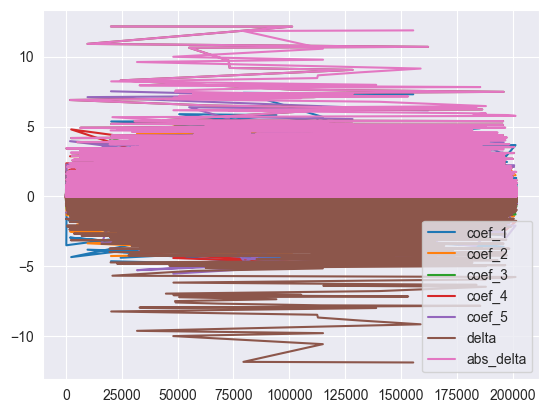

In [67]:
# does this graph make sense?
tok_coef.sort_values("delta").plot()

In [68]:
pipeline["vect"].get_feature_names_out().shape
pipeline["clf"].coef_[0,:].shape

(201796,)

In [69]:
pipeline["tfidf"].get_feature_names_out()

array(['x0', 'x1', 'x2', ..., 'x201793', 'x201794', 'x201795'],
      dtype=object)

In [70]:
 print(len(pipeline["tfidf"].get_feature_names_out()), " / ",len(pipeline["vect"].get_feature_names_out()))

201796  /  201796


#### SHAP interpretation

In [71]:
#https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Using%20custom%20functions%20and%20tokenizers.html
def f(X):    
    val = pipeline.predict(X)
    return val

In [72]:
masker = shap.maskers.Text(r"\W") # this will create a basic whitespace tokenizer
explainer = shap.Explainer(f, masker)#, output_names=labels)

In [73]:
true_pred= pd.DataFrame({"true": y_val, "pred": f(X_val)})

In [74]:
true_pred["delta"] = abs(true_pred.true -true_pred.pred)

In [75]:
true_pred.value_counts("delta")
# delta
# 0    80809
# 1    48323
# 2     8514
# 3     2181
# 4     1054
# Name: count, dtype: int64

delta
0    80809
1    48323
2     8514
3     2181
4     1054
Name: count, dtype: int64

#### Explain worst predictions

In [76]:
# explain worst 7 explanation
shap_values_worst = explainer(X_val[true_pred.sort_values("delta", ascending=False).head(7).index])

Partition explainer: 8it [00:15,  3.14s/it]                       


In [77]:
X_val[true_pred.sort_values("delta", ascending=False).head(7).index]


array(['there_PRON nothing_PRON I_PRON could_AUX write_VERB here_ADV that_PRON would_AUX convince_VERB you_PRON there_PRON nothing_PRON I_PRON could_AUX write_VERB here_ADV that_PRON would_AUX convince_VERB you_PRON to_PART play_VERB this_DET game_NOUN if_SCONJ you_PRON do_AUX not_PART already_ADV have_VERB it_PRON but_CCONJ on_ADP the_DET small_ADJ chance_NOUN that_SCONJ you_PRON do_AUX not_PART go_VERB buy_VERB it_PRON play_VERB it_PRON spend_VERB your_PRON eat_VERB bee_NOUN and_CCONJ scale_VERB mountain_NOUN',
       "to_PART stop_VERB console_NOUN production_NOUN what_PRON ahead_ADV by_ADP troubled_ADJ officially_ADV announce_VERB it_PRON would_AUX end_VERB production_NOUN of_ADP its_PRON game_NOUN console_NOUN and_CCONJ restructure_NOUN to_PART concentrate_VERB on_ADP sell_VERB game_NOUN software_NOUN for_ADP its_PRON rival_NOUN '_PART equipment_NOUN will_AUX restructure_VERB its_PRON overseas_ADJ sale_NOUN unit_NOUN and_CCONJ affiliate_NOUN to_PART cut_VERB cost_NOUN we_PRON be_A

In [78]:
true_pred.sort_values("delta", ascending=False).head(7)

true  pred  delta
59833      5     1      4
132777     5     1      4
126702     5     1      4
43763      1     5      4
132722     1     5      4
132724     1     5      4
117707     1     5      4

In [79]:
shap.plots.text(shap_values_worst)

#### Explain best predictions

In [80]:
shap_values_best = explainer(X_val[true_pred.sort_values("delta", ascending=False).tail(7).index])

In [81]:
shap.plots.text(shap_values_worst)

#### Explain example observation

In [82]:
explain_obv(y_train, X_val, y_val, pipeline, i=10, n_features=10)

True: 3 --> Pred: 3 | Prob: 0.33


In [83]:
explain_obv(y_train, X_val, y_val, pipeline, i=100, n_features=10)

True: 2 --> Pred: 2 | Prob: 0.67


## XGB 

In [84]:
%%time 
# pipeline = Pipeline(xgb_steps)
# pipeline.fit(X_train, y_train-1)
# print("Training_Score: ", pipeline.score(X_train, y_train-1), " / Val. Score: ", pipeline.score(X_val, y_val-1))

CPU times: total: 0 ns
Wall time: 1e+03 µs


In [85]:
#LR Result: Training_Score:  0.6106515049882348  / Val. Score:  0.5436077256691818
#XGB: Training_Score:  0.7842903433027048  / Val. Score:  0.4886109553452914

#LR 0.25*sample Training_Score:  0.6574957410562181  / Val. Score:  0.5226007950028393
#XGB 0.7581061896649631  / Val. Score:  0.43878478137421917
#Weaker parameters: 0.40954003407155026  / Val. Score:  0.38225440090857465

#Training_Score:  0.5758446905167518  / Val. Score:  0.49630891538898353

# Tuned df_min and df_max, as well of ngram number

# 250K obs, headline and body: Training_Score:  0.7014157288217403  / Val. Score:  0.5736543607725669
# same only body: Training_Score:  0.6837767911329734  / Val. Score:  0.5496553829118191
# same only head: Training_Score:  0.49153721389962485  / Val. Score:  0.45453964693606663
# as above, all, C = 0.95: Training_Score:  0.7480222740388198  / Val. Score:  0.5698568295227887
# C =0.15: Training_Score:  0.63208086228497  / Val. Score:  0.5675783107729219
# C = 0.05: Training_Score:  0.5883668189222857  / Val. Score:  0.5544324642783626b

# Word2Vec

In [86]:
# Word2Vec is not a single algorithm but a combination of two techniques – CBOW (Continuous bag of words) and Skip-gram model. 
# Both of these are shallow neural networks which map word(s) to the target variable which is also a word(s). 
# Both of these techniques learn weights which act as word vector representations.

In [87]:
%%time
# wordpunct_tokenize will split pretty much at all special symbols and treat them as separate units. word_tokenize on the other hand keeps things like 're together.
# tokenization of reviews with postagging
tokenizer = nltk.WordPunctTokenizer() # extract the tokens from string of words or sentences in the form of Alphabetic and Non-Alphabetic character

X_us_tok = [tokenizer.tokenize(review) for review in X_us]
print ("Tokenize the first review:")
print (X_us_tok[0])

Tokenize the first review:
['I_PRON', 'purchase_VERB', 'this_DET', 'remote_ADJ', 'control_NOUN', 'to_PART', 'make_VERB', 'watch_VERB', 'DVD_PROPN', "'", 's_PART', 'on_ADP', 'the_DET', 'easier_ADV', 'I_PRON', 'have_VERB', 'problem_NOUN', 'get_VERB', 'it_PRON', 'to_PART', 'work_VERB', 'consistantly_ADV', 'right_ADV', 'out_ADP', 'of_ADP', 'the_DET', 'box_NOUN', 'I_PRON', 'have_VERB', 'to_PART', 'press_VERB', 'most_ADJ', 'of_ADP', 'the_DET', 'button_NOUN', 'very_ADV', 'hard_ADV', 'to_PART', 'get_VERB', 'they_PRON', 'to_PART', 'work_VERB', 'I_PRON', 'hope_VERB', 'it_PRON', 'would_AUX', 'get_VERB', 'well_ADJ', 'but_CCONJ', 'it_PRON', 'only_ADV', 'get_VERB', 'bad_ADJ', 'I_PRON', 'be_AUX', 'now_ADV', 'back_ADV', 'to_ADP', 'use_VERB', 'the_DET', 'game_NOUN', 'controler_NOUN', 'and_CCONJ', 'throw_VERB', 'the_DET', 'remote_ADJ', 'control_NOUN', 'away_ADV', 'br_X', 'br_X', 'would_AUX', 'never_ADV', 'recommend_VERB', 'this_DET', 'product_NOUN']
CPU times: total: 46.8 s
Wall time: 1min 14s


### most frequent words

In [88]:
from collections import defaultdict 

word_freq = defaultdict(int)
for sent in X_us_tok:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

187833

In [89]:
sorted(word_freq, key=word_freq.get, reverse=True)

['the_DET',
 'be_AUX',
 'I_PRON',
 'and_CCONJ',
 'a_DET',
 'it_PRON',
 'game_NOUN',
 'to_PART',
 'of_ADP',
 'you_PRON',
 'not_PART',
 'in_ADP',
 'for_ADP',
 'but_CCONJ',
 'this_DET',
 'have_VERB',
 'with_ADP',
 'to_ADP',
 'on_ADP',
 'do_AUX',
 'that_PRON',
 'they_PRON',
 'play_VERB',
 'get_VERB',
 'my_PRON',
 'can_AUX',
 'this_PRON',
 'if_SCONJ',
 'have_AUX',
 'good_ADJ',
 'just_ADV',
 'that_SCONJ',
 'or_CCONJ',
 'your_PRON',
 'will_AUX',
 'so_ADV',
 'time_NOUN',
 'from_ADP',
 'there_PRON',
 'make_VERB',
 'very_ADV',
 'do_VERB',
 'would_AUX',
 'at_ADP',
 'great_ADJ',
 'when_SCONJ',
 'buy_VERB',
 'out_ADP',
 'up_ADP',
 'go_VERB',
 'an_DET',
 'really_ADV',
 'like_ADP',
 'as_ADP',
 'use_VERB',
 'work_VERB',
 'what_PRON',
 'be_VERB',
 'no_DET',
 'even_ADV',
 'br_X',
 'as_SCONJ',
 'other_ADJ',
 'which_PRON',
 'because_SCONJ',
 "'",
 'some_DET',
 'all_DET',
 'thing_NOUN',
 'look_VERB',
 's_PART',
 'say_VERB',
 'by_ADP',
 'well_ADV',
 'want_VERB',
 'also_ADV',
 'think_VERB',
 'more_ADJ',
 'ta

## self-trained model

### train the model

In [90]:
# %%time
# # define function of self-trained w2v
# def train_w2v_model(w2v_model, X):
#     ''' building vocabulary, build unique word of vocabulary
#     '''
#     w2v_model.build_vocab(X, progress_per=1000)

#     w2v_model.train(X, 
#                 total_examples= w2v_model.corpus_count, 
#                 epochs=w2v_model.epochs # how many times you want to iterate the entire dataset
#     )

#     return w2v_model

In [91]:
# %%time
# # init w2v model
# w2v_model = word2vec.Word2Vec(
#                               # sentences=tokenized_texts, # the corpus iterable in the model constructor --> will automatically train the model. build_vocab and train can be saved. What's the difference of 2 training methods?
#                               vector_size=300, # desired no. of features/independent variables
#                               window=10, # context window size
#                               min_count=2, # Ignores all words with total frequency lower than 2.     
#                               workers=4, # no.of cores
#                               sg = 1, # 1 for skip-gram model
#                               negative = 10 # for negative sampling
# )

In [92]:
# %%time
# # build vocab and train the model
# train_w2v_model(X_us_tok)

In [93]:
# # save the model
# w2v_model.save(path+"/data/trained_model/word2vec_selftrained_w_pos_0505.model")

### load model with posttag

In [94]:
# # load the pre-trained model
from gensim.models import KeyedVectors
w2v_model = KeyedVectors.load(path+'/data/trained_model/word2vec_selftrained_w_pos_0505.model', mmap='r')

### Similarity check

In [95]:
# t-SNE visualizations
def tsnescatterplot(model, word, list_names, feature_size):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, feature_size), dtype='f') 
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays) # min(n_samples, n_features)=19
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(12)

    
    plt.xlim(Y[:, 0].min()-5, Y[:, 0].max()+5)
    plt.ylim(Y[:, 1].min()-1, Y[:, 1].max()*1.1)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

In [96]:
# check the features in the w2v model
w2v_model.wv.key_to_index

{'the_DET': 0,
 'be_AUX': 1,
 'I_PRON': 2,
 'and_CCONJ': 3,
 'a_DET': 4,
 'it_PRON': 5,
 'game_NOUN': 6,
 'to_PART': 7,
 'of_ADP': 8,
 'you_PRON': 9,
 'not_PART': 10,
 'in_ADP': 11,
 'for_ADP': 12,
 'but_CCONJ': 13,
 'this_DET': 14,
 'have_VERB': 15,
 'with_ADP': 16,
 'to_ADP': 17,
 'on_ADP': 18,
 'do_AUX': 19,
 'that_PRON': 20,
 'they_PRON': 21,
 'play_VERB': 22,
 'get_VERB': 23,
 'my_PRON': 24,
 'can_AUX': 25,
 'this_PRON': 26,
 'if_SCONJ': 27,
 'have_AUX': 28,
 'good_ADJ': 29,
 'just_ADV': 30,
 'that_SCONJ': 31,
 'or_CCONJ': 32,
 'your_PRON': 33,
 'will_AUX': 34,
 'so_ADV': 35,
 'time_NOUN': 36,
 'from_ADP': 37,
 'there_PRON': 38,
 'make_VERB': 39,
 'very_ADV': 40,
 'do_VERB': 41,
 'would_AUX': 42,
 'at_ADP': 43,
 'great_ADJ': 44,
 'when_SCONJ': 45,
 'buy_VERB': 46,
 'out_ADP': 47,
 'up_ADP': 48,
 'go_VERB': 49,
 'an_DET': 50,
 'really_ADV': 51,
 'like_ADP': 52,
 'as_ADP': 53,
 'use_VERB': 54,
 'work_VERB': 55,
 'what_PRON': 56,
 'be_VERB': 57,
 'no_DET': 58,
 'even_ADV': 59,
 'br_X

In [97]:
# test similarity of good_ADJ / good
# vector = w2v_model.wv['good_ADJ']  # get numpy vector of a word
sims = w2v_model.wv.most_similar('great_ADJ', topn=10)  # get other similar words
sims

[('awesome_ADJ', 0.7472450137138367),
 ('fantastic_ADJ', 0.7424927949905396),
 ('wonderful_ADJ', 0.7363248467445374),
 ('good_ADJ', 0.7355349063873291),
 ('excellent_ADJ', 0.7301567792892456),
 ('amazing_ADJ', 0.6793864369392395),
 ('geat_ADJ', 0.672211229801178),
 ('reallly_ADJ', 0.6534988284111023),
 ('vey_ADV', 0.6518805623054504),
 ('grea_ADJ', 0.645374596118927)]

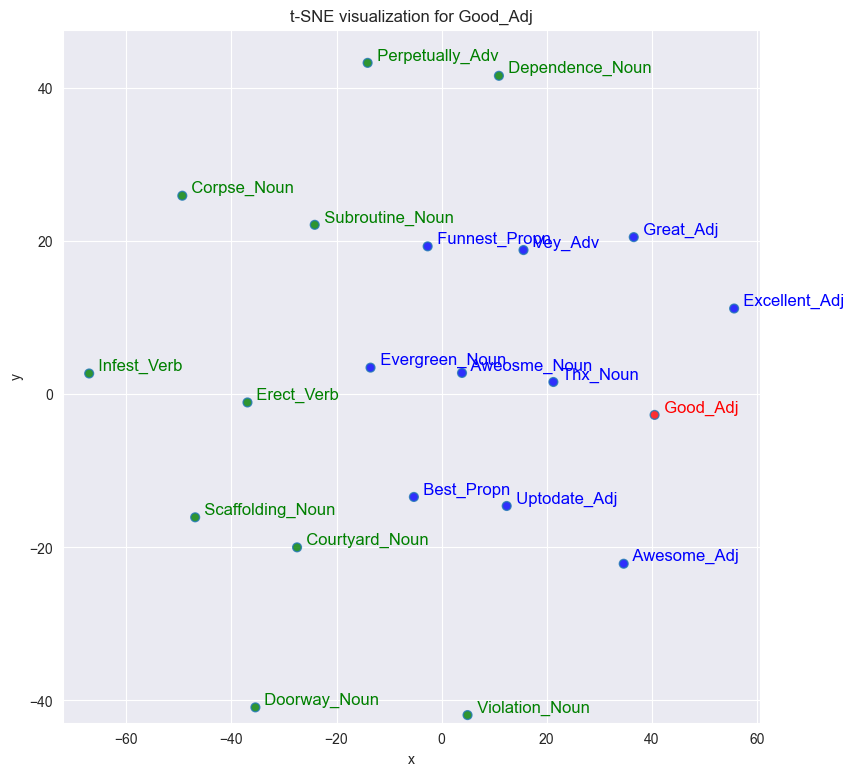

In [98]:
# plot for self-trained model > 10 Most similar words vs. 10 Most dissimilar
tsnescatterplot(w2v_model, 'good_ADJ', [i[0] for i in w2v_model.wv.most_similar(negative=["good_ADJ"])], 300)

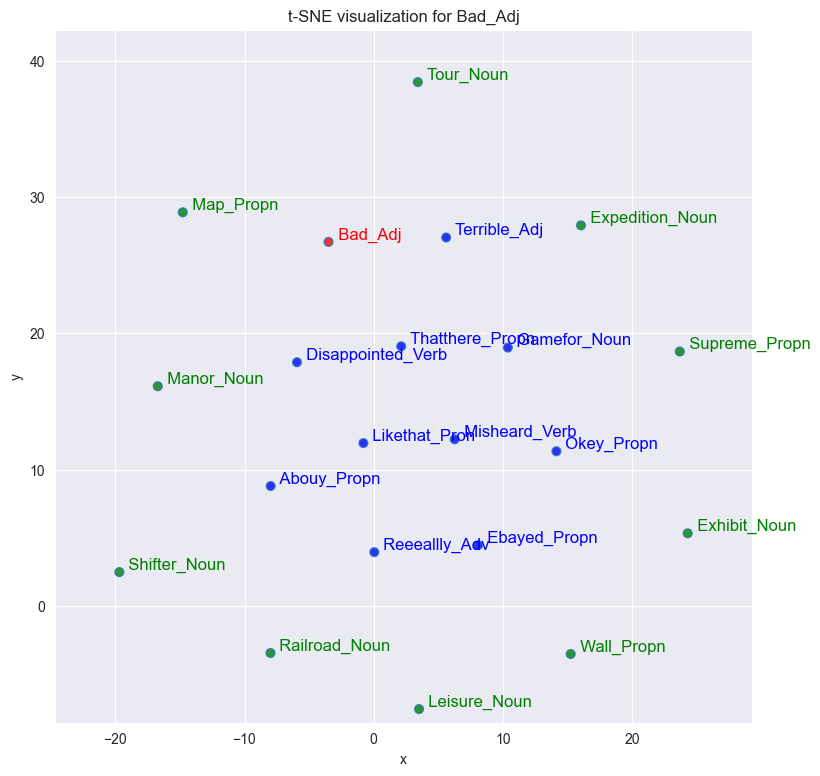

In [99]:
tsnescatterplot(w2v_model, 'bad_ADJ', [i[0] for i in w2v_model.wv.most_similar(negative=["bad_ADJ"])], 300)

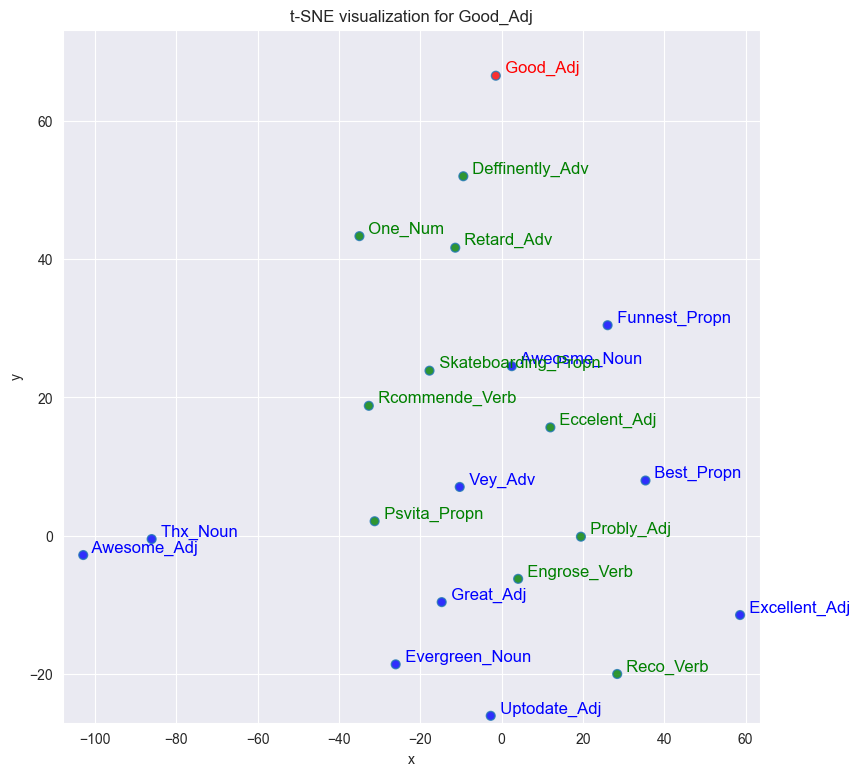

In [100]:
# plot for self-trained model > 1-10 most similar vs 11-20 most similar
tsnescatterplot(w2v_model, "good_ADJ", [t[0] for t in w2v_model.wv.most_similar(positive=["good_ADJ"], topn=20)][10:], 300)

### create feature matrix

In [101]:
# Create feature vectors
def create_features(review_tokens, model):
    num_features = model.vector_size
    features = np.zeros((len(review_tokens), num_features), dtype="float32")
    for i, tokens in enumerate(review_tokens):
        for token in tokens:
            if token in model.wv.key_to_index:
                features[i] += model.wv.get_vector(token)
    return features

In [102]:
# %%time
# # create features. Output of create_features is array and needs to be converted to dataframe
# X_train_features = pd.DataFrame(create_features(X_train, w2v_model))
# X_test_features = pd.DataFrame(create_features(X_test, w2v_model))
# X_val_features = pd.DataFrame(create_features(X_val, w2v_model))

# # save the feature vector
# X_train_features.to_csv(path + "/word2vec_selftrained_w_pos_X_train_features_0505.csv", index=False)
# X_test_features.to_csv(path + "/word2vec_selftrained_w_pos_X_test_features_0505.csv", index=False)
# X_val_features.to_csv(path + "/word2vec_selftrained_w_pos_X_val_features_0505.csv", index=False)

In [103]:
X_train_features = pd.read_csv(path + "/data/processed/word2vec_selftrained_w_pos_X_train_features_0505.csv")
X_test_features = pd.read_csv(path + "/data/processed/word2vec_selftrained_w_pos_X_test_features_0505.csv")
X_val_features = pd.read_csv(path + "/data/processed/word2vec_selftrained_w_pos_X_val_features_0505.csv")

In [104]:
X_train_features.head()

0         1         2         3         4         5         6   
0 -1.817746  1.632575 -0.136044 -0.763183 -0.072465  1.118950 -1.188249  \
1 -0.660998  0.593664 -0.049470 -0.277521 -0.026351  0.406891 -0.432090   
2 -0.826248  0.742079 -0.061838 -0.346901 -0.032939  0.508614 -0.540113   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4 -1.652496  1.484159 -0.123676 -0.693803 -0.065878  1.017228 -1.080226   

          7         8         9  ...       290       291       292       293   
0 -2.814384 -1.625409 -3.148237  ...  0.702778 -0.780773  4.569367 -1.262136  \
1 -1.023412 -0.591058 -1.144813  ...  0.255556 -0.283917  1.661588 -0.458959   
2 -1.279265 -0.738822 -1.431017  ...  0.319444 -0.354897  2.076985 -0.573698   
3  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
4 -2.558531 -1.477644 -2.862034  ...  0.638889 -0.709793  4.153970 -1.147397   

        294       295       296       297       298       299  
0 -1.745576  3.138171  0.583846 -1.357972  1.258063  2.647350  
1 -0.634755  1.141153  0.212308 -0.493808  0.457477  0.962673  
2 -0.793444  1.426441  0.265385 -0.617260  0.571847  1.203341  
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
4 -1.586888  2.852882  0.530769 -1.234520  1.143693  2.406682  

[5 rows x 300 columns]

### logistic regression

In [105]:
%%time
pipeline = Pipeline(lr_steps_w2v)
pipeline.fit(X_train_features, y_train)
print("Training_Score: ", pipeline.score(X_train_features, y_train), " / Val. Score: ", pipeline.score(X_val_features, y_val))

# Result of parameters C=0.5, max_iter=1000
# Training_Score:  0.2528259565663341  / Val. Score:  0.2515598270881098

# Result of parameters multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1

Training_Score:  0.2528259565663341  / Val. Score:  0.2515598270881098
CPU times: total: 1min 2s
Wall time: 24.1 s


Start predicting
Finished predicting
Global accuracy: 0.2515598270881098


Predicted class         1         2         3         4         5
Actual class                                                     
1                0.225715  0.177505  0.118135  0.166016  0.210670
2                0.228042  0.260964  0.258645  0.257990  0.160322
3                0.202354  0.236710  0.270693  0.224254  0.180674
4                0.194917  0.208243  0.244093  0.223544  0.192439
5                0.148971  0.116578  0.108434  0.128196  0.255895

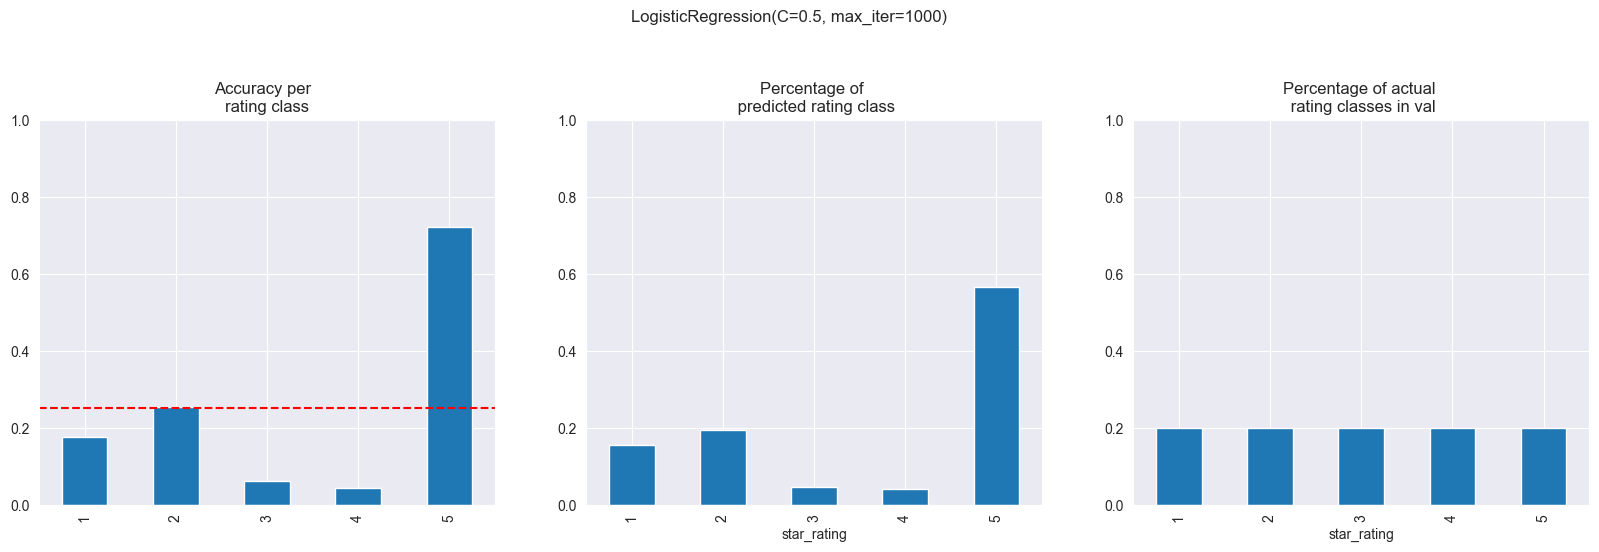

In [114]:
assess_on_val(pipeline, X_val_features, y_val)
confusion_matrix = pd.crosstab(
        y_val, pipeline.predict(X_val_features), 
        rownames=['Actual class'], colnames=['Predicted class'], normalize=1
    )

confusion_matrix
# lr_params = dict(C=0.5, max_iter=1000)
# Global accuracy: 0.2515598270881098
# Predicted class	1	2	3	4	5
# Actual class					
# 1	0.225715	0.177505	0.118135	0.166016	0.210670
# 2	0.228042	0.260964	0.258645	0.257990	0.160322
# 3	0.202354	0.236710	0.270693	0.224254	0.180674
# 4	0.194917	0.208243	0.244093	0.223544	0.192439
# 5	0.148971	0.116578	0.108434	0.128196	0.255895

# lr_params = dict(multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1) 


In [108]:
pd.DataFrame(pipeline.predict(X_val_features)).value_counts()

# lr_params = dict(C=0.5, max_iter=1000)
# 5    79646
# 2    27295
# 1    21917
# 3     6391
# 4     5632

# lr_params = dict(multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1) 


5    79646
2    27295
1    21917
3     6391
4     5632
Name: count, dtype: int64

In [109]:
print(classification_report(y_val, pipeline.predict(X_val_features)))

# lr_params = dict(C=0.5, max_iter=1000)
#               precision    recall  f1-score   support

#            1       0.23      0.18      0.20     28261
#            2       0.26      0.25      0.26     27996
#            3       0.27      0.06      0.10     28279
#            4       0.22      0.04      0.07     28102
#            5       0.26      0.72      0.38     28243

#     accuracy                           0.25    140881
#    macro avg       0.25      0.25      0.20    140881
# weighted avg       0.25      0.25      0.20    140881

# lr_params = dict(multi_class='multinomial', solver='lbfgs', max_iter=1000, verbose=1) 

              precision    recall  f1-score   support

           1       0.23      0.18      0.20     28261
           2       0.26      0.25      0.26     27996
           3       0.27      0.06      0.10     28279
           4       0.22      0.04      0.07     28102
           5       0.26      0.72      0.38     28243

    accuracy                           0.25    140881
   macro avg       0.25      0.25      0.20    140881
weighted avg       0.25      0.25      0.20    140881



In [110]:
# the result of w2v works much worse compared to tfidf / count-vectorizer
# probably because the data which is used for training is too small
# reference: https://datascience.stackexchange.com/questions/19160/why-word2vec-performs-much-worst-than-both-countvectorizer-and-tfidfvectorizer

### logistic regression with features from tfidf (TBD. performance reason)

In [111]:
# # use sne to plot vectors 2D
# from sklearn import manifold

# tsne = manifold.TSNE()
# viz = tsne.fit_transform(docs_pca)

In [112]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots()
# ax.margins(0.05) 

# zero_indices = np.where(news_train.target == 0)[0]
# one_indices = np.where(news_train.target == 1)[0]

# ax.plot(viz[zero_indices,0], viz[zero_indices,1], marker='o', linestyle='', 
#         ms=8, alpha=0.3, label=news_train.target_names[0])
# ax.plot(viz[one_indices,0], viz[one_indices,1], marker='o', linestyle='', 
#         ms=8, alpha=0.3, label=news_train.target_names[1])
# ax.legend()

# plt.show()

In [113]:
stop

NameError: name 'stop' is not defined

# Parameter fine-tunung

## RandomsearchCV

In [101]:
hyperparameter_grid = {
    'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3,0.5,0.75,1],
    'vect__ngram_range': [(1,1),(1, 2),(1,3),(2,3)], 
    'vect__min_df': [0,0.005,0.01,0.025, 0.05,0.1],
    'vect__max_df' : [0.3, 0.35,0.5,0.75,0.9],    
}

random_cv = RandomizedSearchCV(estimator=pipeline,
            param_distributions=hyperparameter_grid,
            cv=4, 
            n_iter=15,
            scoring = 'accuracy', # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
            n_jobs = -1,
            verbose = 1, 
            return_train_score = True,
            random_state=42)

random_cv.fit(X_train, y_train)

Fitting 4 folds for each of 15 candidates, totalling 60 fits



3 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\EQDIYCI\OneDrive - Allianz\TRAININGS\DATASCIENCE_ACADEMY\PROJECT\ds_project\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\EQDIYCI\OneDrive - Allianz\TRAININGS\DATASCIENCE_ACADEMY\PROJECT\ds_project\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\EQDIYCI\OneDrive - Allianz\TRAININGS\DATASCIENCE_ACADEMY\PROJECT\ds_project\lib\site-packages\sklearn\linear_model\_logistic.py",

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('vect',
                                              CountVectorizer(max_df=0.35,
                                                              min_df=0.001,
                                                              ngram_range=(1,
                                                                           3))),
                                             ('tfidf', TfidfTransformer()),
                                             ('clf',
                                              LogisticRegression(C=0.5,
                                                                 max_iter=1000))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3,
                                                   0.5, 0.75, 1],
                                        'vect__max_df': [0.3, 0.35, 0.5, 0.75,
                                                         0.9],
                                        'vect__min_df': [0, 0.005, 0.01, 0.025,
                                                         0.05, 0.1],
                                        'vect__ngram_range': [(1, 1), (1, 2),
                                                              (1, 3), (2, 3)]},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=1)

In [ ]:
# result of RandomSearchCV for LR
# RandomizedSearchCV(cv=4,
#                    estimator=Pipeline(steps=[('vect',
#                                               CountVectorizer(max_df=0.35,
#                                                               min_df=0.001,
#                                                               ngram_range=(1,
#                                                                            3))),
#                                              ('tfidf', TfidfTransformer()),
#                                              ('clf',
#                                               LogisticRegression(C=0.5,
#                                                                  max_iter=1000))]),
#                    n_iter=15, n_jobs=-1,
#                    param_distributions={'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3,
#                                                    0.5, 0.75, 1],
#                                         'vect__max_df': [0.3, 0.35, 0.5, 0.75,
#                                                          0.9],
#                                         'vect__min_df': [0, 0.005, 0.01, 0.025,
#                                                          0.05, 0.1],
#                                         'vect__ngram_range': [(1, 1), (1, 2),
#                                                               (1, 3), (2, 3)]},
#                    random_state=42, return_train_score=True, scoring='accuracy',
#                    verbose=1)

In [102]:
best_pipe = random_cv.best_estimator_
best_pipe

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.9, min_df=0.005, ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=0.3, max_iter=1000))])

In [103]:
best_pipe.score(X_val, y_val)

0.55593728039977

Start predicting
Finished predicting
Global accuracy: 0.55593728039977


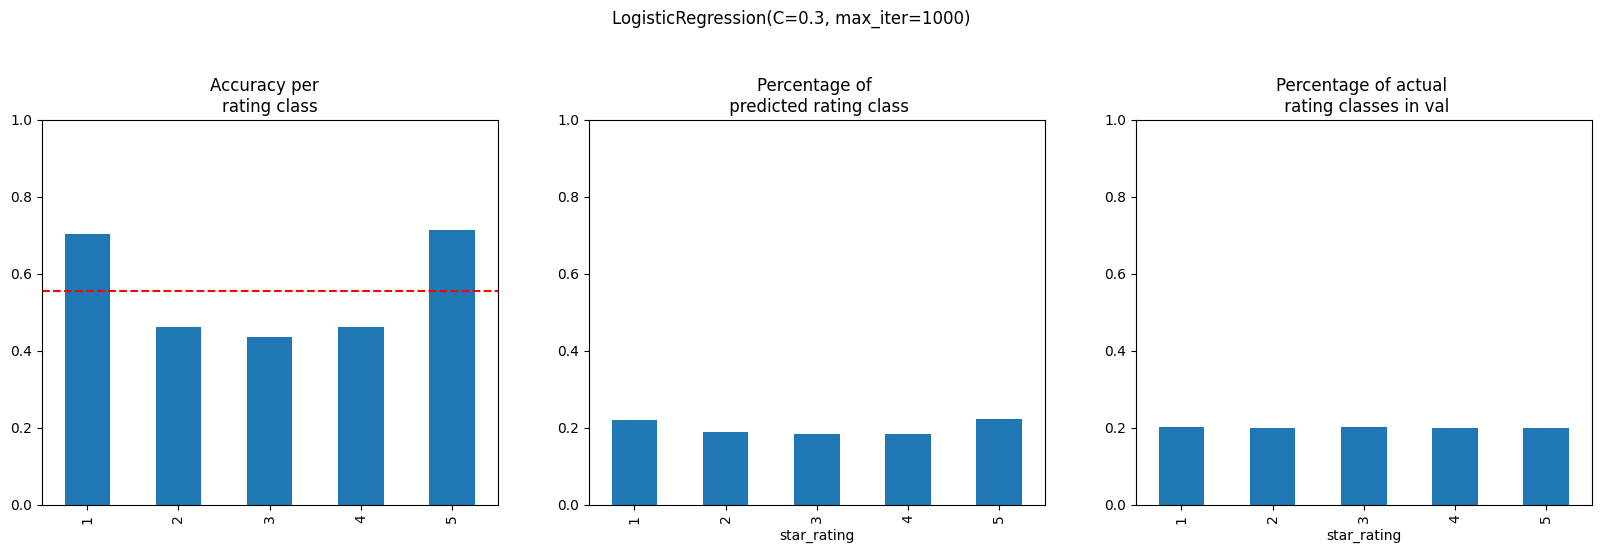

In [104]:
assess_on_val(best_pipe, X_val, y_val);

## Gridsearch

In [105]:
hyperparameter_grid = {
    'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3,0.5,0.75,1],
    #'vect__ngram_range': [(1,1),(1, 2),(1,3),(2,3)], 
    'vect__min_df': [0.0001],
    'vect__max_df' : [0.075, 0.1, 0.125],        
}
vectorizer_params = dict(ngram_range=(1, 3), min_df=0.0001, max_df=0.35-0.25)

grid_cv = GridSearchCV(estimator=pipeline,
            param_grid=hyperparameter_grid,
            cv=4,             
            scoring = 'accuracy', # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
            n_jobs = -1,
            verbose = 1, 
            return_train_score = True)

grid_cv.fit(X_train, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(max_df=0.35,
                                                        min_df=0.001,
                                                        ngram_range=(1, 3))),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        LogisticRegression(C=0.5,
                                                           max_iter=1000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3, 0.5, 0.75, 1],
                         'vect__max_df': [0.075, 0.1, 0.125],
                         'vect__min_df': [0.0001]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
# Result of GridSearchCV for LR
# GridSearchCV
# GridSearchCV(cv=4,
#              estimator=Pipeline(steps=[('vect',
#                                         CountVectorizer(max_df=0.35,
#                                                         min_df=0.001,
#                                                         ngram_range=(1, 3))),
#                                        ('tfidf', TfidfTransformer()),
#                                        ('clf',
#                                         LogisticRegression(C=0.5,
#                                                            max_iter=1000))]),
#              n_jobs=-1,
#              param_grid={'clf__C': [0.01, 0.1, 0.015, 0.2, 0.3, 0.5, 0.75, 1],
#                          'vect__max_df': [0.075, 0.1, 0.125],
#                          'vect__min_df': [0.0001]},
#              return_train_score=True, scoring='accuracy', verbose=1)

In [106]:
best_pipe = grid_cv.best_estimator_
best_pipe

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.1, min_df=0.0001,
                                 ngram_range=(1, 3))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=0.5, max_iter=1000))])

In [107]:
best_pipe.score(X_val, y_val)

0.5735975752585516

Start predicting
Finished predicting
Global accuracy: 0.5735975752585516


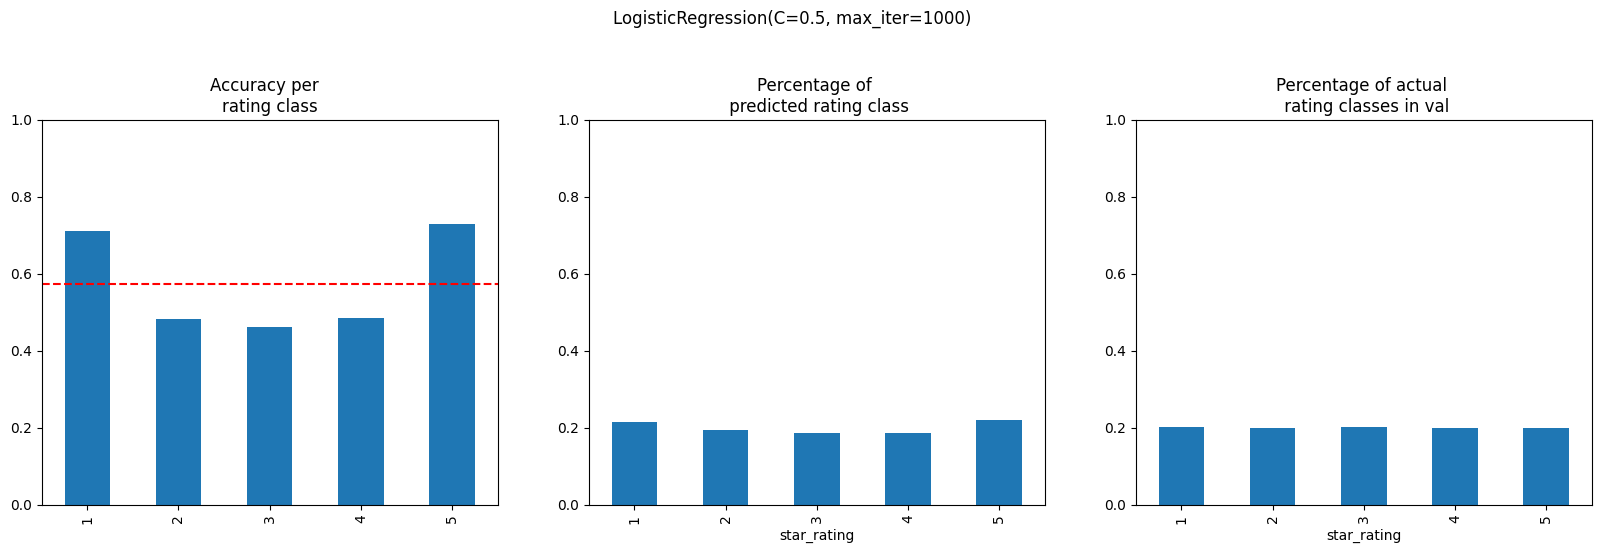

In [108]:
assess_on_val(best_pipe, X_val, y_val);

In [ ]:
import optuna 
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objective(trial):
    """return the f1-score"""

    # search space
    n_estimators =  trial.suggest_int('n_estimators', low=100, high=200, step=50)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    min_samples_split = trial.suggest_int('min_samples_split', low=2, high=4, step=1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', low=1, high=5, step=1)
    max_depth = trial.suggest_int('max_depth', low=5, high=7, step=1)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])

    # random forest classifier object
    rfc = RandomForestClassifier(n_estimators=n_estimators, 
                                                  criterion=criterion,
                                                  min_samples_split=min_samples_split,
                                                  min_samples_leaf=min_samples_leaf,
                                                  max_depth=max_depth,
                                                  max_features=max_features,
                                                  random_state=42)
    score =  cross_val_score(estimator=rfc, 
                             X=X_train, 
                             y=y_train, 
                             scoring='f1_micro',
                             cv=5,
                             n_jobs=-1).mean()
    
    return score

# create a study (aim to maximize score)
study = optuna.create_study(sampler=TPESampler(), direction='maximize')

# perform hyperparamter tuning (while timing the process)
time_start = time.time()
study.optimize(objective, n_trials=100)
time_bayesian = time.time() - time_start

# store result in a data frame 
values_bayesian = [100, study.best_trial.number, study.best_trial.value, time_bayesian]
results_bayesian = pd.DataFrame([values_bayesian], columns = columns)

In [ ]:
import optuna
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score


# -- Define the objective function
def objective(trial):
    # -- Instantiate scaler
    # (a) List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust'])

    # (b) Define your scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    # -- Instantiate dimensionality reduction
     # (a) List all dimensionality reduction options
    dim_red = trial.suggest_categorical("dim_red", ["PCA", None])

    # (b) Define the PCA algorithm and its hyperparameters
    if dim_red == "PCA":
        pca_n_components=trial.suggest_int("pca_n_components", 2, 30) # suggest an integer from 2 to 30
        dimen_red_algorithm=PCA(n_components=pca_n_components)
    # (c) No dimensionality reduction option
    else:
        dimen_red_algorithm='passthrough'

    # -- Instantiate estimator model
    knn_n_neighbors=trial.suggest_int("knn_n_neighbors", 1, 19, 2) # suggest an integer from 1 to with step 2
    knn_metric=trial.suggest_categorical("knn_metric", ['euclidean', 'manhattan', 'minkowski'])
    knn_weights=trial.suggest_categorical("knn_weights", ['uniform', 'distance'])

    estimator=KNeighborsClassifier(n_neighbors=knn_n_neighbors, metric=knn_metric, weights=knn_weights)

    # SW
    lr_params = dict(C=0.5, max_iter=1000)
    vectorizer_params = dict(ngram_range=(1, 3), min_df=0.00, max_df=0.35)#, max_features=10000) # 0.001 performs good and reduces runtime
    tfidf_params = dict(norm='l2')
    varth_params = dict(threshold=0.00005/100)
    percth_params = dict(score_func= selpc_fun, percentile = 95)
    # Supervised Pipeline




    lr_steps = [ ("vect", CountVectorizer(**vectorizer_params)),
            ("tfidf", TfidfTransformer(**tfidf_params)),
            #("percth", SelectPercentile(**percth_params)),
            #("varth", VarianceThreshold(**varth_params)),
            ("clf", LogisticRegression(**lr_params))]

    pipeline = Pipeline(lr_steps)

    #SW
    
    # -- Make a pipeline
    pipeline = make_pipeline(scaler, dimen_red_algorithm, estimator)

    # -- Evaluate the score by cross-validation
    score = cross_val_score(pipeline, X_train, y_train, scoring='f1')
    f1 = score.mean() # calculate the mean of scores
    return f1

study = optuna.create_study(direction="maximize") # maximise the score during tuning
study.optimize(objective, n_trials=100) # run the objective function 100 times

print(study.best_trial) # print the best performing pipeline

## Results after parameter finetuning

In [ ]:
lr_params = dict(C=0.5, max_iter=1000)
vectorizer_params = dict(ngram_range=(1, 3), min_df=0.001, max_df=0.35)#, max_features=10000) # 0.001 performs good and reduces runtime
tfidf_params = dict(norm='l2')
word2vec_params = dict(min_count=1, window = 5)
#percth_params = dict(score_func= selpc_fun, percentile = 95)
# Supervised Pipeline

lrw2v_steps = [ ("vect", W2VTransformer(**word2vec_params)),
        #("tfidf", TfidfTransformer(**tfidf_params)),
        #("percth", SelectPercentile(**percth_params)),
        #("varth", VarianceThreshold(**varth_params)),
        ("clf", LogisticRegression(**lr_params))]

pipeline = Pipeline(lrw2v_steps)

pipeline.fit(X_train, y_train)

KeyError: "word 'got game christma gift much anticip great workout huge ufc fan workout time natur thought would great option unfortun think far mani break move far slow like hard break sweat realli friend let play kinda thing ask fun challeng workout slightest' not in vocabulary"

In [95]:
pd.DataFrame(pipeline.get_params().keys())

0
0                   memory
1                    steps
2                  verbose
3                     vect
4                    tfidf
5                      clf
6           vect__analyzer
7             vect__binary
8       vect__decode_error
9              vect__dtype
10          vect__encoding
11             vect__input
12         vect__lowercase
13            vect__max_df
14      vect__max_features
15            vect__min_df
16       vect__ngram_range
17      vect__preprocessor
18        vect__stop_words
19     vect__strip_accents
20     vect__token_pattern
21         vect__tokenizer
22        vect__vocabulary
23             tfidf__norm
24       tfidf__smooth_idf
25     tfidf__sublinear_tf
26          tfidf__use_idf
27                  clf__C
28       clf__class_weight
29               clf__dual
30      clf__fit_intercept
31  clf__intercept_scaling
32           clf__l1_ratio
33           clf__max_iter
34        clf__multi_class
35             clf__n_jobs
36            clf__penalty
37       clf__random_state
38             clf__solver
39                clf__tol
40            clf__verbose
41         clf__warm_start

In [71]:
pd.DataFrame.from_dict(lr_pipeline.steps[0][1].vocabulary_, orient="index").reset_index().sort_values(by=0)

index     0
2207       aa     0
1219      aaa     1
343   abandon     2
1635     abil     3
44        abl     4
...       ...   ...
2095      zip  3411
770     zombi  3412
2235     zone  3413
2326     zoom  3414
2808    zumba  3415

[3416 rows x 2 columns]

In [99]:
dict(zip(feature_names.ravel() , X_train_vectorized.mean(axis=1))) 
#stopwrods: xbox, nintendo, game, amazon, christma, gamecub, im, mario, around, basketbal

{'aa': matrix([[0.00034342]]),
 'aaa': matrix([[0.00059032]]),
 'ab': matrix([[0.00056063]]),
 'abacus': matrix([[0.00032889]]),
 'abandon': matrix([[0.00041731]]),
 'abba': matrix([[0.00022538]]),
 'abc': matrix([[0.00030099]]),
 'abd': matrix([[0.0004535]]),
 'abe': matrix([[0.00020932]]),
 'abil': matrix([[0.00026331]]),
 'abilit': matrix([[0.00029385]]),
 'abit': matrix([[0.00039747]]),
 'abl': matrix([[0.00049444]]),
 'abnorm': matrix([[0.00059856]]),
 'abomin': matrix([[0.00100907]]),
 'abort': matrix([[0.00063437]]),
 'abound': matrix([[0.00019273]]),
 'abras': matrix([[0.00037401]]),
 'abroad': matrix([[0.0004026]]),
 'abrupt': matrix([[0.00032712]]),
 'absenc': matrix([[0.00089944]]),
 'absent': matrix([[0.00090666]]),
 'absolut': matrix([[0.00101455]]),
 'absolutley': matrix([[0.00020835]]),
 'absorb': matrix([[0.00046401]]),
 'abstract': matrix([[0.00028085]]),
 'absurd': matrix([[0.00121324]]),
 'abt': matrix([[0.00052331]]),
 'abund': matrix([[0.00038551]]),
 'abus': matri

# Classification

In [46]:
clf_mnNB = MultinomialNB().fit(X_train_vectorized, y_train)
clf_knn = KNeighborsClassifier(n_neighbors=40).fit(X_train_vectorized, y_train)
clf_lr = LogisticRegression(max_iter=1000).fit(X_train_vectorized, y_train)
clf_lr_L2_05 = LogisticRegression( C=0.5,max_iter=1000).fit(X_train_vectorized, y_train)
clf_lr_L1_05 = LogisticRegression(penalty="l1", C=0.25,max_iter=1000, solver= "saga").fit(X_train_vectorized, y_train)
clf_xgb = xgb.XGBClassifier(base_score=0.2, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.5,
              max_delta_step=0, max_depth=20, min_child_weight=1,# missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)



# Appendix

In [45]:
# Assessement of results
# Add vine flag as feature!

In [35]:
#metrics.accuracy_score(predicted[y_val==rc], y_val[y_val==rc])

Start predicting
Finished predicting
Global accuracy: 0.4617830777967064


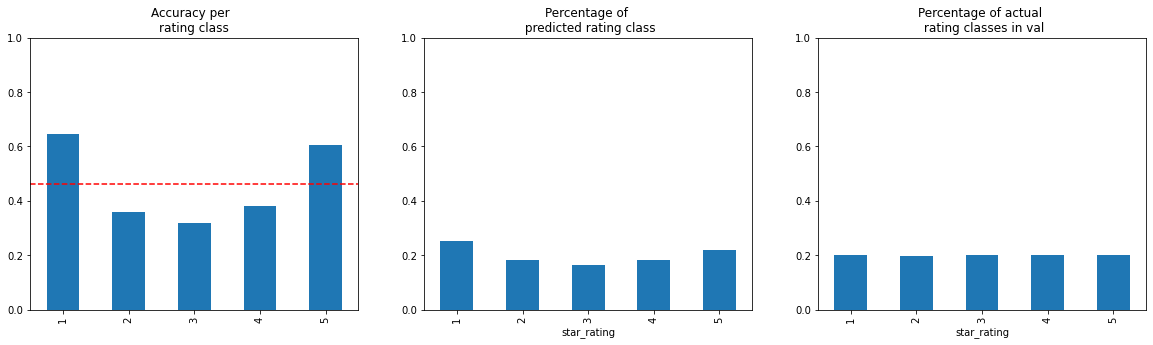

In [47]:
assess_on_val(clf_mnNB, X_val_vectorized, y_val)

Start predicting
Finished predicting
Global accuracy: 0.49646507666098805


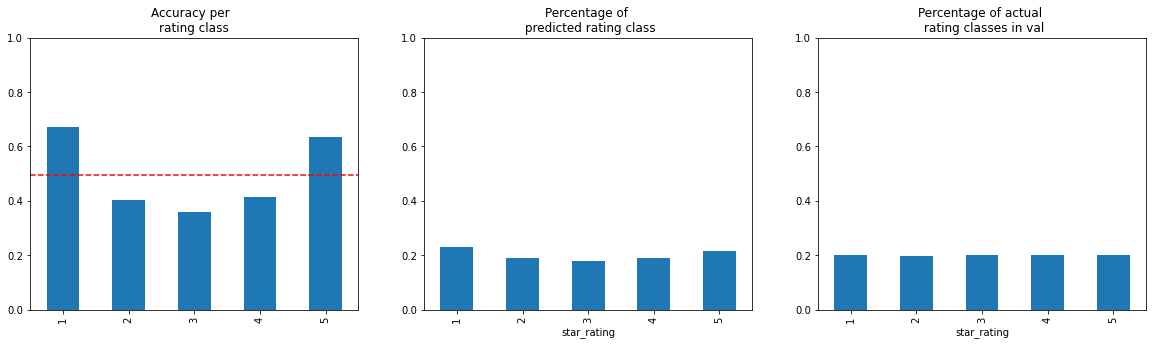

In [36]:
# New sample
assess_on_val(clf_lr_L2_05, X_val_vectorized, y_val);

In [46]:
clf_lr_L2_05.score(X_val_vectorized, y_val)

0.49646507666098805

Start predicting
Finished predicting
Global accuracy: 0.5043441226575809


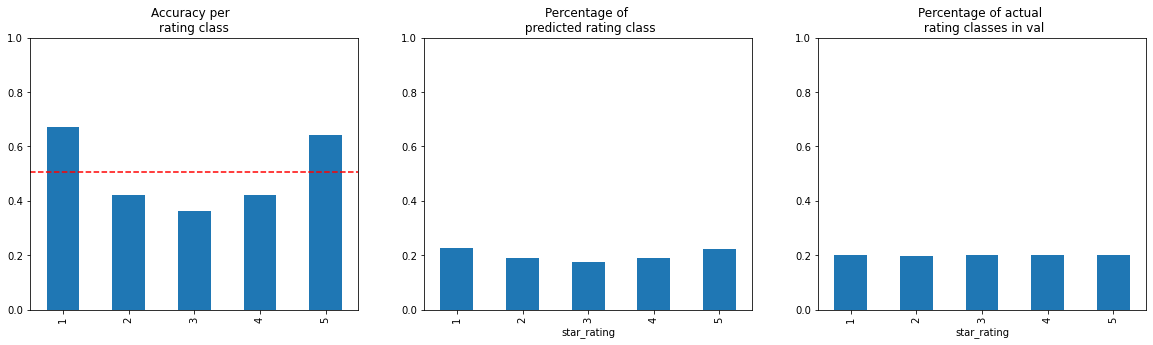

In [106]:
assess_on_val(clf_lr_L2_05, X_val_vectorized, y_val);

Start predicting
Finished predicting
Global accuracy: 0.49622373651334467


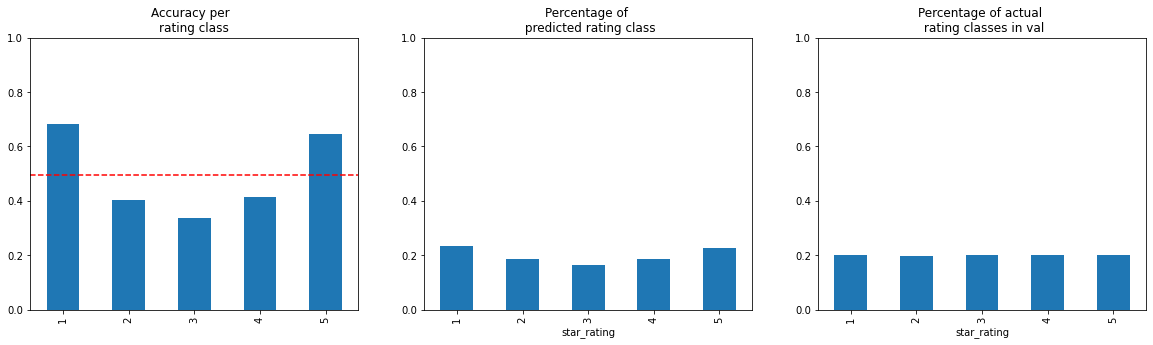

In [105]:
assess_on_val(clf_lr_L1_05, X_val_vectorized, y_val);

In [95]:
#Analyse words predicting class 0
coefs = pd.DataFrame.from_dict({"coef": clf_lr_L2_05.coef_[0,:], "feature": feature_names.ravel()}, orient="index")
coefs = coefs.transpose()
coefs["abs_coef"]=np.abs(coefs.coef)
coefs.sort_values(by="abs_coef", ascending=False).head(40)

coef     feature  abs_coef
2663  -6.34947       great   6.34947
6921  6.003601       worst  6.003601
6764  5.691694        wast  5.691694
6136  5.129915     terribl  5.129915
3605 -4.973701        love  4.973701
2931  4.359777     horribl  4.359777
5092   4.23451      return   4.23451
1609  4.134234  disappoint  4.134234
4424 -4.101356     perfect  4.101356
2479  4.002121      garbag  4.002121
540  -3.994098        best  3.994098
4578  3.877165        poor  3.877165
2418 -3.841276         fun  3.841276
392  -3.736629      awesom  3.736629
1772  3.723408         drm  3.723408
2598 -3.643766        good  3.643766
3904  3.561819       money  3.561819
4079 -3.549802        nice  3.549802
3312  3.534719        junk  3.534719
2015  3.525487        even  3.525487
384   3.475898          aw  3.475898
4289 -3.378695      overal  3.378695
2041 -3.216886       excel  3.216886
578  -3.171486         bit  3.171486
6194 -3.141913      though  3.141913
383   3.029937       avoid  3.029937
1831   2.91977          ea   2.91977
6352   2.90989       trash   2.90989
179  -2.899537        amaz  2.899537
6586  2.852078     useless  2.852078
6920  2.834552        wors  2.834552
3552 -2.833531       littl  2.833531
1300  2.808448        crap  2.808448
5959   2.79621        suck   2.79621
4958  2.787174      refund  2.787174
65   -2.762473      addict  2.762473
2141 -2.699301     fantast  2.699301
1154 -2.675159   complaint  2.675159
3038   2.66813      imposs   2.66813
1951 -2.657773       enjoy  2.657773

coef  feature
1069 -6.373212    great
1416 -5.001928     love
1748 -4.128307  perfect
221    -4.0107     best
990  -3.869566      fun
...        ...      ...
2014  4.254924   return
1172  4.397509  horribl
2430   5.17903  terribl
2661  5.757634     wast
2726   6.07725    worst

[2779 rows x 2 columns]

Start predicting
Finished predicting
Global accuracy: 0.5320414537194775


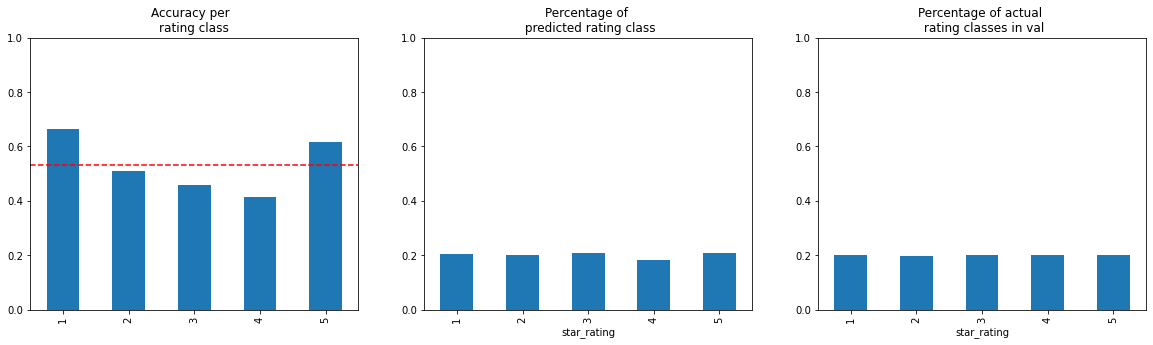

In [109]:
assess_on_val(clf_xgb, X_val_vectorized, y_val);
# 10000 features (/10 for variance threshold)

Start predicting
Finished predicting
Global accuracy: 0.5330777967064169


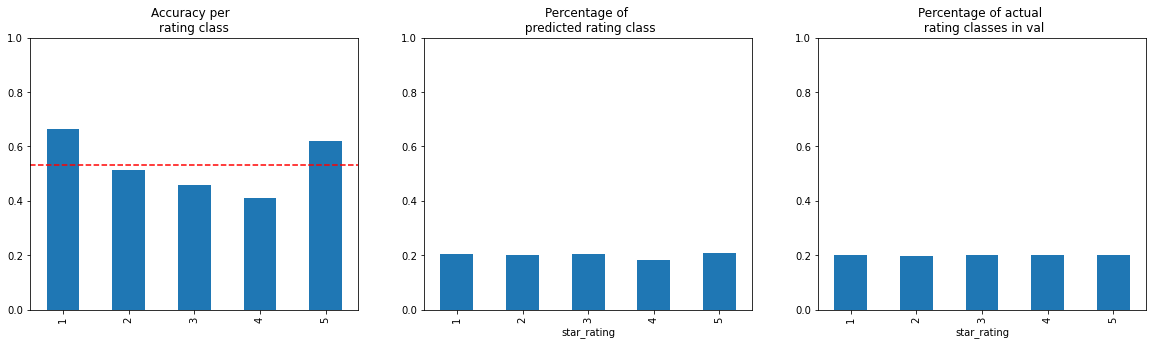

In [114]:
assess_on_val(clf_xgb, X_val_vectorized, y_val);
#/2 => 4000 features

Start predicting
Finished predicting
Global accuracy: 0.5342703009653605


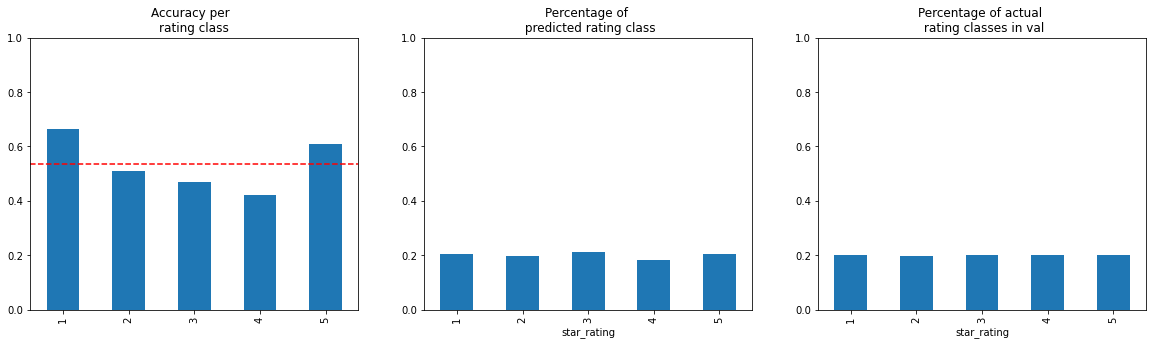

In [121]:
assess_on_val(clf_xgb, X_val_vectorized, y_val);
#1 

# Reference

In [131]:
# Reference for w2v
# https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794